In [1]:
import os
import requests

if not os.path.exists("CatsVsDogs.zip"):
  res = requests.get("https://github.com/bipinkrish/my-ml/releases/download/v0.0/CatsVsDogs.zip")
  with open("CatsVsDogs.zip","wb") as file: file.write(res.content)

In [4]:
import zipfile

zip_file_path = "CatsVsDogs.zip"
extract_dir = "CatsVsDogs"

if not os.path.exists(extract_dir):
    os.mkdir(extract_dir)
    with zipfile.ZipFile(zip_file_path, "r") as zip_file:
      zip_file.extractall(extract_dir)

cat_dir = f"{extract_dir}/{extract_dir}/Cat"
dog_dir = f"{extract_dir}/{extract_dir}/Dog"

In [41]:
from sklearn.model_selection import train_test_split

all_files = os.listdir(cat_dir) + os.listdir(dog_dir)

cat_labels = [0] * len(os.listdir(cat_dir))
dog_labels = [1] * len(os.listdir(dog_dir))
all_labels = cat_labels + dog_labels

train_files, val_files, train_labels, val_labels = train_test_split(all_files, all_labels, test_size=0.2, random_state=42)
train_paths = [os.path.join(cat_dir, file) if label == 0 else os.path.join(dog_dir, file) for file, label in zip(train_files, train_labels)]
val_paths = [os.path.join(cat_dir, file) if label == 0 else os.path.join(dog_dir, file) for file, label in zip(val_files, val_labels)]

print(len(train_paths))
print(len(val_paths))

20000
5000


In [47]:
import shutil

train_dir = f"{extract_dir}/train"
val_dir = f"{extract_dir}/val"

cat_train = []
dog_train = []
cat_val = []
dog_val = []

if not os.path.exists(train_dir):
    os.makedirs(train_dir + "/cat")
    os.makedirs(train_dir + "/dog")
    os.makedirs(val_dir + "/cat")
    os.makedirs(val_dir + "/dog")

for file in train_paths:
    if cat_dir in file:
        shutil.copy2(file, f"{train_dir}/cat/")
        cat_train.append(file)
    else:
        shutil.copy2(file, f"{train_dir}/dog/")
        dog_train.append(file)

for file in val_paths:
    if cat_dir in file:
        shutil.copy2(file, f"{val_dir}/cat/")
        cat_val.append(file)
    else:
        shutil.copy2(file, f"{val_dir}/dog/")
        dog_val.append(file)

In [46]:
print(len(os.listdir(f"{train_dir}/cat")))
print(len(os.listdir(f"{train_dir}/dog")))
print(len(os.listdir(f"{val_dir}/cat")))
print(len(os.listdir(f"{val_dir}/dog")))

9985
10015
2515
2485


In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

#model.summary()

In [40]:
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image

model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=['acc'])

batch_size = 32
epochs = 1

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=batch_size, class_mode='binary')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(150, 150), batch_size=batch_size, class_mode='binary')

for epoch in range(epochs):
    print('Epoch', epoch)
    
    steps_per_epoch = train_generator.n // batch_size
    for step in range(steps_per_epoch):
        try:
            x_batch, y_batch = train_generator.next()
        except Image.UnidentifiedImageError:
            continue # skip problematic image
        
        # train on batch
        loss = model.train_on_batch(x_batch, y_batch)
        # print('Step', step, 'loss', loss)
        
    # evaluate the model on validation data
    val_steps = val_generator.n // batch_size
    val_loss, val_acc = 0.0, 0.0
    for i in range(val_steps):
        try:
            x_batch, y_batch = val_generator.next()
        except Image.UnidentifiedImageError:
            continue # skip problematic image
        
        # evaluate on batch
        loss, acc = model.evaluate(x_batch, y_batch, verbose=0)
        val_loss += loss
        val_acc += acc
    
    val_loss /= val_steps
    val_acc /= val_steps
    print('Validation loss', val_loss, 'validation accuracy', val_acc)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 0


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Validation loss 0.34981803744076156 validation accuracy 0.8449519230769231


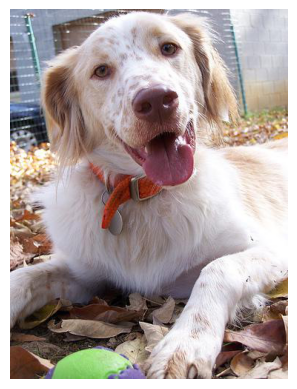

1/1 [==============================] - 0s 22ms/step
Dog


In [45]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = dog_val[200] # change the value to test differnet images # cal_val
img = Image.open(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

img = img.resize((150, 150))
x = np.array(img)
x = x / 255.0
x = np.expand_dims(x, axis=0)

predicted_class = int(round(model.predict(x)[0][0]))
if predicted_class == 0:
  print("Cat")
else:
  print("Dog")